# Compare the analytical solution and the neural net mask

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
sys.path.append("..")
from utils.model import Net_mask
from utils.data import Data
from scripts.parameters import get_parameters, get_parameters_2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [39]:
model = Net_mask()
model2 = Net_mask()
model3 = Net_mask()
run = 0
run2 = 0
run3 = 0
outer_folder = 'rml_map'
#outer_folder_2 = 'map_numpy'
outer_folder_2 = 'rml_positive'
outer_folder_3 = 'rml_negative'
name = '../saved_models/' + str(outer_folder) + '/' + str(run) + '/model_weights.pth'
name2 = '../saved_models/' + str(outer_folder_2) + '/' + str(run2) + '/model_weights.pth'
name3 = '../saved_models/' + str(outer_folder_3) + '/' + str(run3) + '/model_weights.pth'
model.load_state_dict(torch.load(name))
model2.load_state_dict(torch.load(name2))
model3.load_state_dict(torch.load(name3))
model.eval()
model2.eval()
model3.eval()

Net_mask(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [40]:
tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps, tensor_Q_m, sigma2_eps, tau2 = get_parameters()
tensor_mu_m2, tensor_Sigma_m2, tensor_mu_eps2, tensor_Sigma_eps2, tensor_Q_m2, sigma2_eps2, tau22 = get_parameters_2()
data = Data(tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps)
data2 = Data(tensor_mu_m2, tensor_Sigma_m2, tensor_mu_eps2, tensor_Sigma_eps2)

In [41]:

tensor_data = torch.zeros(1, 20)
tensor_d_sample =  MultivariateNormal(loc=torch.zeros(10), covariance_matrix=(torch.eye(10)*1)).sample(sample_shape=(1,))
tensor_n_masked = torch.randint(10, (1,))
tensor_masks = torch.rand(1, 10).argsort(dim=1)
tensor_masks = (tensor_masks < tensor_n_masked.unsqueeze(1))*1
tensor_data[:,:10] = tensor_d_sample*tensor_masks
tensor_data[:,10:] = tensor_masks
tensor_data

tensor([[-1.0842, -0.8002, -0.0696, -0.0000, -0.3479, -0.0000,  0.0000,  1.1703,
          0.0000,  0.6072,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  1.0000]])

In [42]:
tensor_data = data.get_tensor_data(1, [2.5, 1.5, 1.6, -3], [1, 3, 5, 8])

In [43]:
"""
tensor_raw = data.get_tensor_data(1)
tensor_raw = torch.zeros(20)
tensor_raw[0] = 0
tensor_raw[3] = -1
tensor_raw[9] = 2.5
tensor_raw[10] = 1
tensor_raw[13] = 1
tensor_raw[19] = 1
tensor_raw = tensor_raw.unsqueeze(0)
print(tensor_raw)
tensor_data = tensor_raw
"""

'\ntensor_raw = data.get_tensor_data(1)\ntensor_raw = torch.zeros(20)\ntensor_raw[0] = 0\ntensor_raw[3] = -1\ntensor_raw[9] = 2.5\ntensor_raw[10] = 1\ntensor_raw[13] = 1\ntensor_raw[19] = 1\ntensor_raw = tensor_raw.unsqueeze(0)\nprint(tensor_raw)\ntensor_data = tensor_raw\n'

In [44]:
#tensor_data = torch.zeros(20)
#tensor_data[2] = 3
#tensor_data[7] = 2
##tensor_data[8] = -3
#tensor_data[12] = 1
#tensor_data[17] = 1
##tensor_data[18] = 1
#tensor_data = tensor_data.unsqueeze(0)
#print(tensor_data)

In [45]:
post, _ = data.get_tensor_posterior(tensor_data[0])
post2, _ = data2.get_tensor_posterior(tensor_data[0])
out_raw = model(tensor_data)
out_raw2 = model2(tensor_data)
out_raw3 = model3(tensor_data)
out = out_raw[0].detach().numpy()
out2 = out_raw2[0].detach().numpy()
out3 = out_raw3[0].detach().numpy()
d = tensor_data[0][:10]
mask = tensor_data[0][10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]

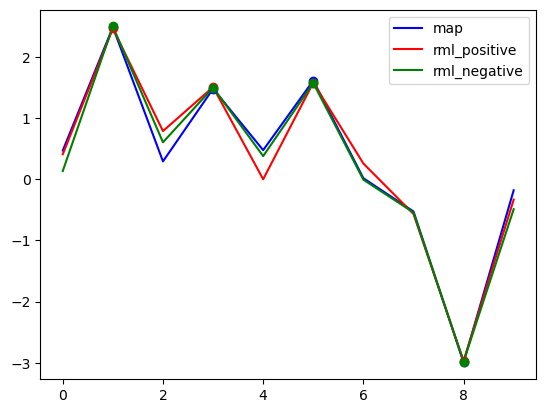

In [46]:
#plt.plot(range(10), post, 'y')
#plt.plot(range(10), post2, 'y')
plt.plot(range(10), out, 'b')
plt.plot(range(10), out2, 'r')
plt.plot(range(10), out3, 'g')
#plt.plot(location, post[location_raw], 'yo')
#plt.plot(location, post2[location_raw], 'yo')
plt.plot(location, out[location_raw], 'bo')
plt.plot(location, out2[location_raw], 'ro')
plt.plot(location, out3[location_raw], 'go')
#plt.legend(['analytical tau2=1000', 'analytical tau2=1', 'map'])
#plt.legend(['analytical tau2=1', 'map', 'rml_positive', 'rml_negative'])
plt.legend(['map', 'rml_positive', 'rml_negative'])
#plt.legend(['analytical tau2=1000', 'analytical tau2=1', 'rml_positive', 'rml_negative'])
#plt.axis([0,10,-3,3])

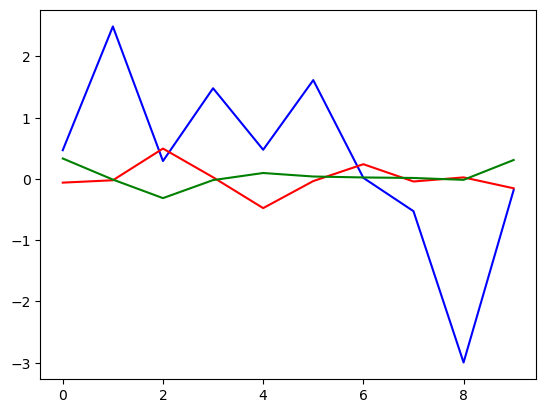

In [47]:
plt.plot(range(10), out, 'b')
plt.plot(range(10), out2-out, 'r')
plt.plot(range(10), out-out3, 'g')

In [48]:
from utils.loss3 import Loss
loss = Loss()
import utils.loss3 as l3
l3l = l3.Loss()
tensor_data = tensor_data.type(torch.DoubleTensor)
post = post.type(torch.DoubleTensor)
out_raw = out_raw.type(torch.DoubleTensor)
out_raw2 = out_raw2.type(torch.DoubleTensor)
loss1 = loss.loss(tensor_data, torch.unsqueeze(post, 0), 'm', 'c', 'i') 
loss2 = loss.loss(tensor_data, out_raw, 'm', 'c', 'i') 
loss3 = loss.loss(tensor_data, out_raw2, 'm', 'c', 'i') 
l3value = l3l.loss(tensor_data, torch.unsqueeze(post, 0), 'm', 'c', 'i')
print(loss1[0])
print(loss2[0])
print(loss3[0])
print(l3value[0])

tensor(0.1915, dtype=torch.float64)
tensor(0.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1915, dtype=torch.float64)
